In [1]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [2]:
print("TensorFlow version:", tf.__version__)
device_name = tf.test.gpu_device_name()
print('GPU found:' if device_name else 'No GPU found', device_name)
np.random.seed(42)
tf.random.set_seed(42)


TensorFlow version: 2.19.0
GPU found: /device:GPU:0


In [3]:
import tensorflow as tf
import pathlib
import numpy as np

DATASET_PATH = "data/mini_speech_commands_extracted/mini_speech_commands"
data_dir = pathlib.Path(DATASET_PATH)

if not data_dir.exists():
    tf.keras.utils.get_file(
        fname='mini_speech_commands.zip',
        origin='http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
        extract=True,
        cache_dir='.',
        cache_subdir='data'
    )


182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Available commands:', commands)


Available commands: ['stop' 'go' 'left' 'yes' 'no' 'right' 'down' 'up']


In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
filenames = np.array(filenames)
print('Number of total examples:', len(filenames))


Number of total examples: 8000


In [6]:
train_files, test_files = train_test_split(filenames, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)
print('Training samples:', len(train_files))
print('Validation samples:', len(val_files))
print('Testing samples:', len(test_files))


Training samples: 6400
Validation samples: 800
Testing samples: 800


In [7]:
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40, hop_length=160, n_fft=512)
    max_len = 98
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc


In [8]:
X, y = [], []
for file in train_files:
    label = file.split('/')[-2]
    features = extract_features(file)
    X.append(features)
    y.append(label)
X = np.array(X)
y = np.array(y)


In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
commands = label_encoder.classes_
print('Encoded classes:', commands)


Encoded classes: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [10]:
X = X[..., np.newaxis]  # Add a channel dimension for CNN
print(X.shape)


(6400, 40, 98, 1)


In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(40, 98, 1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(commands), activation='softmax')
])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 96, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,507,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,546,056 (5.90 MB)

 Trainable params: 1,546,056 (5.90 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [13]:
history = model.fit(
    X, y_encoded,
    epochs=30,
    batch_size=100,
    validation_split=0.2
)


Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.1310 - loss: 10.4803 - val_accuracy: 0.1414 - val_loss: 2.0779
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1467 - loss: 2.0779 - val_accuracy: 0.1703 - val_loss: 2.0269
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1855 - loss: 2.0176 - val_accuracy: 0.2594 - val_loss: 1.8650
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2933 - loss: 1.8623 - val_accuracy: 0.2961 - val_loss: 1.7702
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3258 - loss: 1.7915 - val_accuracy: 0.3828 - val_loss: 1.6077
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3488 - loss: 1.7028 - val_accuracy: 0.4016 - val_loss: 1.5944
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3755 - loss: 1.6378 - val_accuracy: 0.4406 - val_loss: 1.5049
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4079 - loss: 1.5662 - val_accuracy: 0.4633 

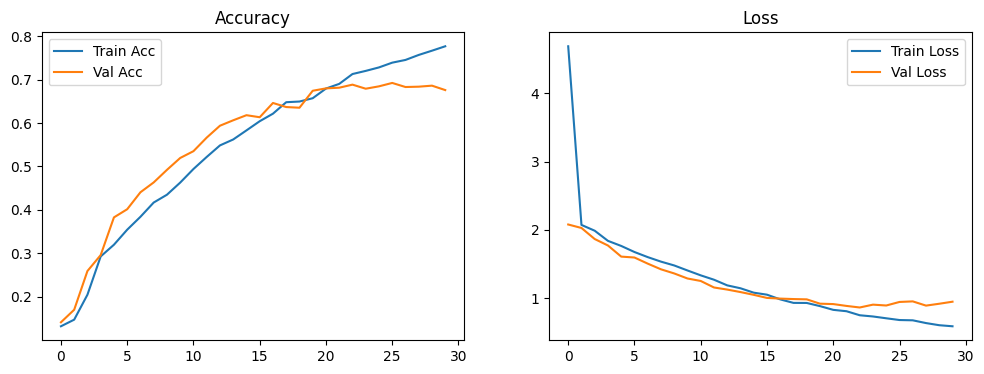

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [15]:
# Extract and preprocess test files similar to training
# Evaluate model performance
test_loss, test_acc = model.evaluate(X, y_encoded)
print('Test accuracy:', test_acc)


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9100 - loss: 0.2854
Test accuracy: 0.8682812452316284


In [16]:
# --- Cell 16: Generate Predictions on Test Data ---
# If you have test_ds (TensorFlow dataset), convert it to arrays:
X_test, y_test = [], []
for file in test_files:
    label = file.split('/')[-2]
    features = extract_features(file)
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test)[..., np.newaxis]
y_test = np.array(y_test)

# Encode test labels using the same encoder
y_test_encoded = label_encoder.transform(y_test)

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


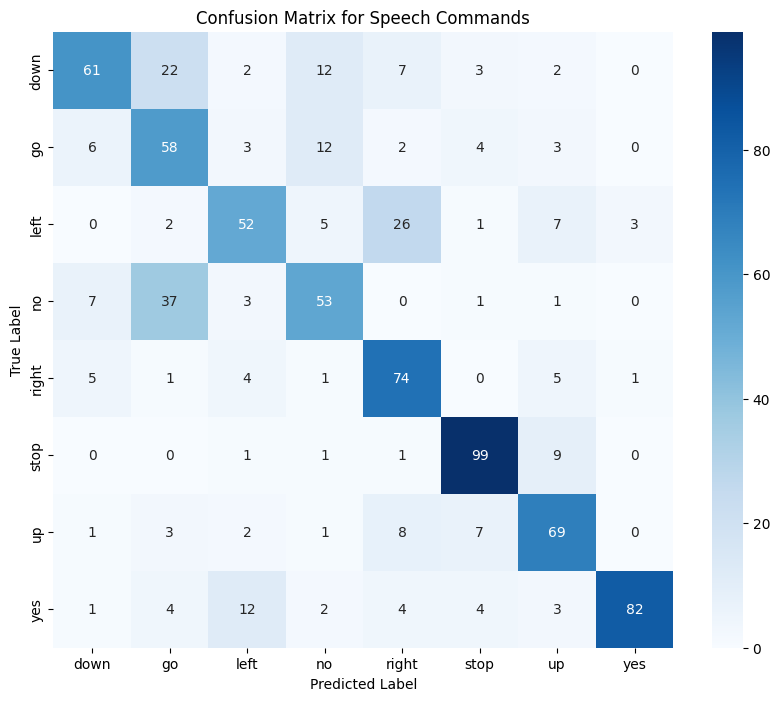

Classification Report:
               precision    recall  f1-score   support

        down       0.75      0.56      0.64       109
          go       0.46      0.66      0.54        88
        left       0.66      0.54      0.59        96
          no       0.61      0.52      0.56       102
       right       0.61      0.81      0.69        91
        stop       0.83      0.89      0.86       111
          up       0.70      0.76      0.73        91
         yes       0.95      0.73      0.83       112

    accuracy                           0.69       800
   macro avg       0.70      0.68      0.68       800
weighted avg       0.71      0.69      0.69       800



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=commands, yticklabels=commands)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Speech Commands')
plt.show()

# Optional: show precision, recall, F1
print("Classification Report:\n", classification_report(y_test_encoded, y_pred, target_names=commands))


/tmp/ipython-input-2770807096.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=commands, y=class_acc, palette='viridis')


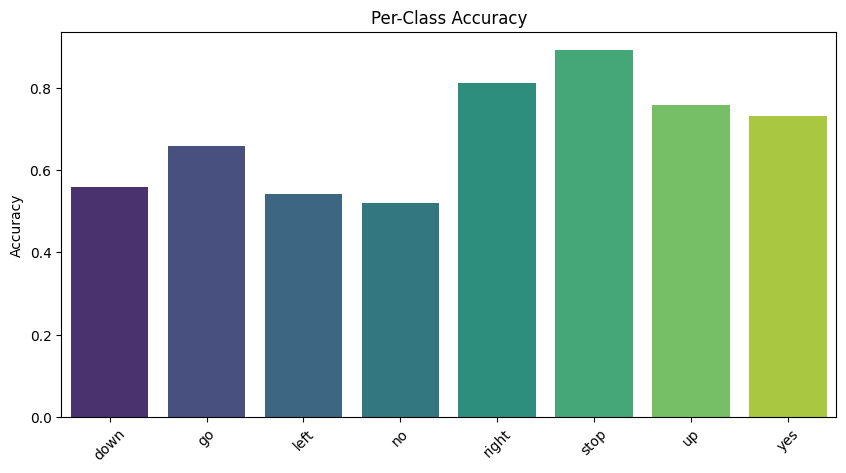

In [18]:
# Calculate per-class accuracy
cm_sum = np.sum(cm, axis=1, keepdims=True)
class_acc = cm.diagonal() / cm_sum.flatten()

plt.figure(figsize=(10, 5))
sns.barplot(x=commands, y=class_acc, palette='viridis')
plt.title('Per-Class Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()


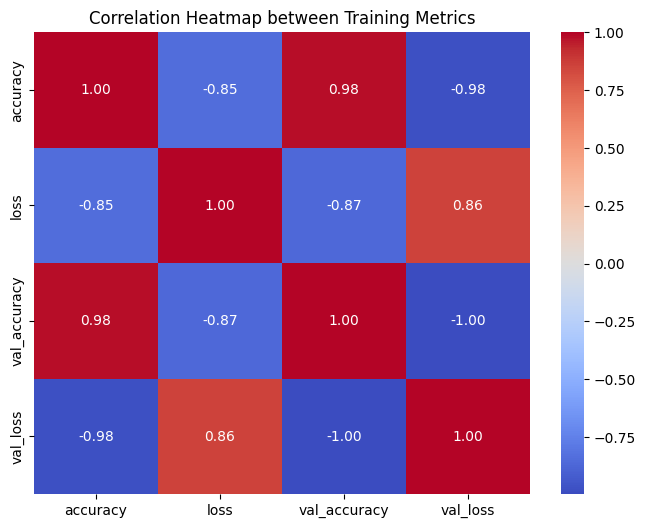

In [19]:
# Create a dataframe of accuracy/loss progression
import pandas as pd

history_df = pd.DataFrame(history.history)
plt.figure(figsize=(8, 6))
sns.heatmap(history_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Training Metrics')
plt.show()


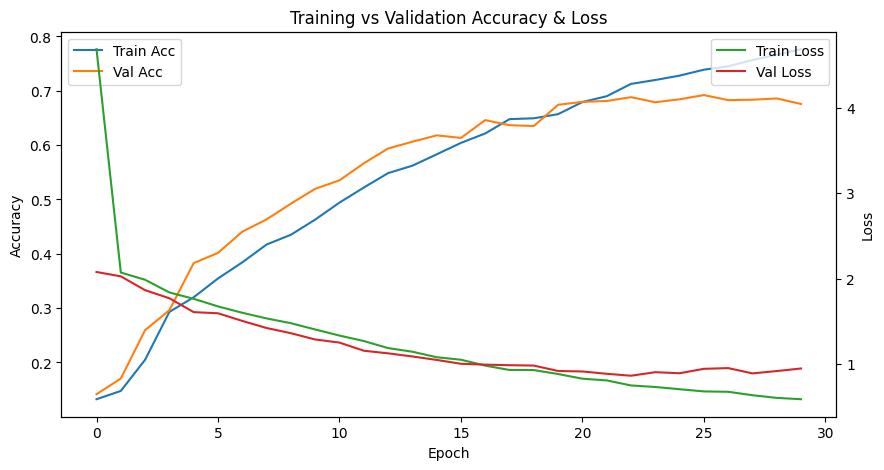

In [20]:
# Final comparison plot (Accuracy vs Loss)
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(history.history['accuracy'], label='Train Acc', color='tab:blue')
ax1.plot(history.history['val_accuracy'], label='Val Acc', color='tab:orange')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(history.history['loss'], label='Train Loss', color='tab:green')
ax2.plot(history.history['val_loss'], label='Val Loss', color='tab:red')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.title('Training vs Validation Accuracy & Loss')
plt.show()


In [21]:
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 96, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,507,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,638,170 (17.69 MB)

 Trainable params: 1,546,056 (5.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,092,114 (11.80 MB)